# AML scAtlas

## Integrated Zhang et al Dataset: Assessment of Batch Effects

Some individual studies were analysed to ascertain the presence of batch effects within a single study. Two high performing batch correction methods were also tested on these datasets.

## Environment Setup

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import anndata as ad
from anndata import AnnData
import matplotlib.pyplot as plt
from scipy import stats
import scvi
from rich import print
from scib_metrics.benchmark import Benchmarker
from scvi.model.utils import mde
from scvi_colab import install
import scanorama

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

if not os.path.exists("outs"):
    os.makedirs("outs")
if not os.path.exists("plots"):
    os.makedirs("plots")

combined_file = 'outs/zhang_filtered.h5ad'
corrected_file = 'outs/zhang_batch_correct.h5ad'

Global seed set to 0
/Users/jwhittle/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/jwhittle/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.9.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.8


In [2]:
import rpy2
%load_ext rpy2.ipython
from rpy2.robjects.packages import importr
# import R tools
base = importr('base')
utils = importr('utils')

In [3]:
%%R
suppressMessages(library(kBET))

## Create Combined AnnData Object

In [4]:
# Read in data files - with cells already filtered
amlP105 = sc.read_h5ad("../amlP105/outs/AMLP105_cell_filtered.h5ad")
amlP106 = sc.read_h5ad("../amlP106/outs/AMLP106_cell_filtered.h5ad")
amlP108 = sc.read_h5ad("../amlP108/outs/AMLP108_cell_filtered.h5ad")
amlP114 = sc.read_h5ad("../amlP114/outs/AMLP114_cell_filtered.h5ad")
amlP115 = sc.read_h5ad("../amlP115/outs/AMLP115_cell_filtered.h5ad")
amlP116 = sc.read_h5ad("../amlP116/outs/AMLP116_cell_filtered.h5ad")
amlP117 = sc.read_h5ad("../amlP117/outs/AMLP117_cell_filtered.h5ad")
amlP118 = sc.read_h5ad("../amlP118/outs/AMLP118_cell_filtered.h5ad")
amlP119 = sc.read_h5ad("../amlP119/outs/AMLP119_cell_filtered.h5ad")
amlP120 = sc.read_h5ad("../amlP120/outs/AMlP120_cell_filtered.h5ad")
amlP122 = sc.read_h5ad("../amlP122/outs/AMLP122_cell_filtered.h5ad")
amlP123 = sc.read_h5ad("../amlP123/outs/AMLP123_cell_filtered.h5ad")
amlP124 = sc.read_h5ad("../amlP124/outs/AMLP124_cell_filtered.h5ad")
data = [amlP105,amlP106,amlP108,amlP114,amlP115,amlP116,amlP117,amlP118,amlP119,
        amlP120,amlP122,amlP123,amlP124]

In [5]:
# Concetenate files
adata = ad.concat(data, merge="same")
# Delete individual datasets to save space
del(amlP105,amlP106,amlP108,amlP114,amlP115,amlP116,amlP117,amlP118,amlP119,
    amlP120,amlP122,amlP123,amlP124)

### Initial QC

In [6]:
# Annotate mitochondrial/ribosomal/hb genes
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))

# Run QC function
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo', 'hb'], percent_top=None, log1p=False, inplace=True)

# Add the total counts per cell
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

#### Plotting QC

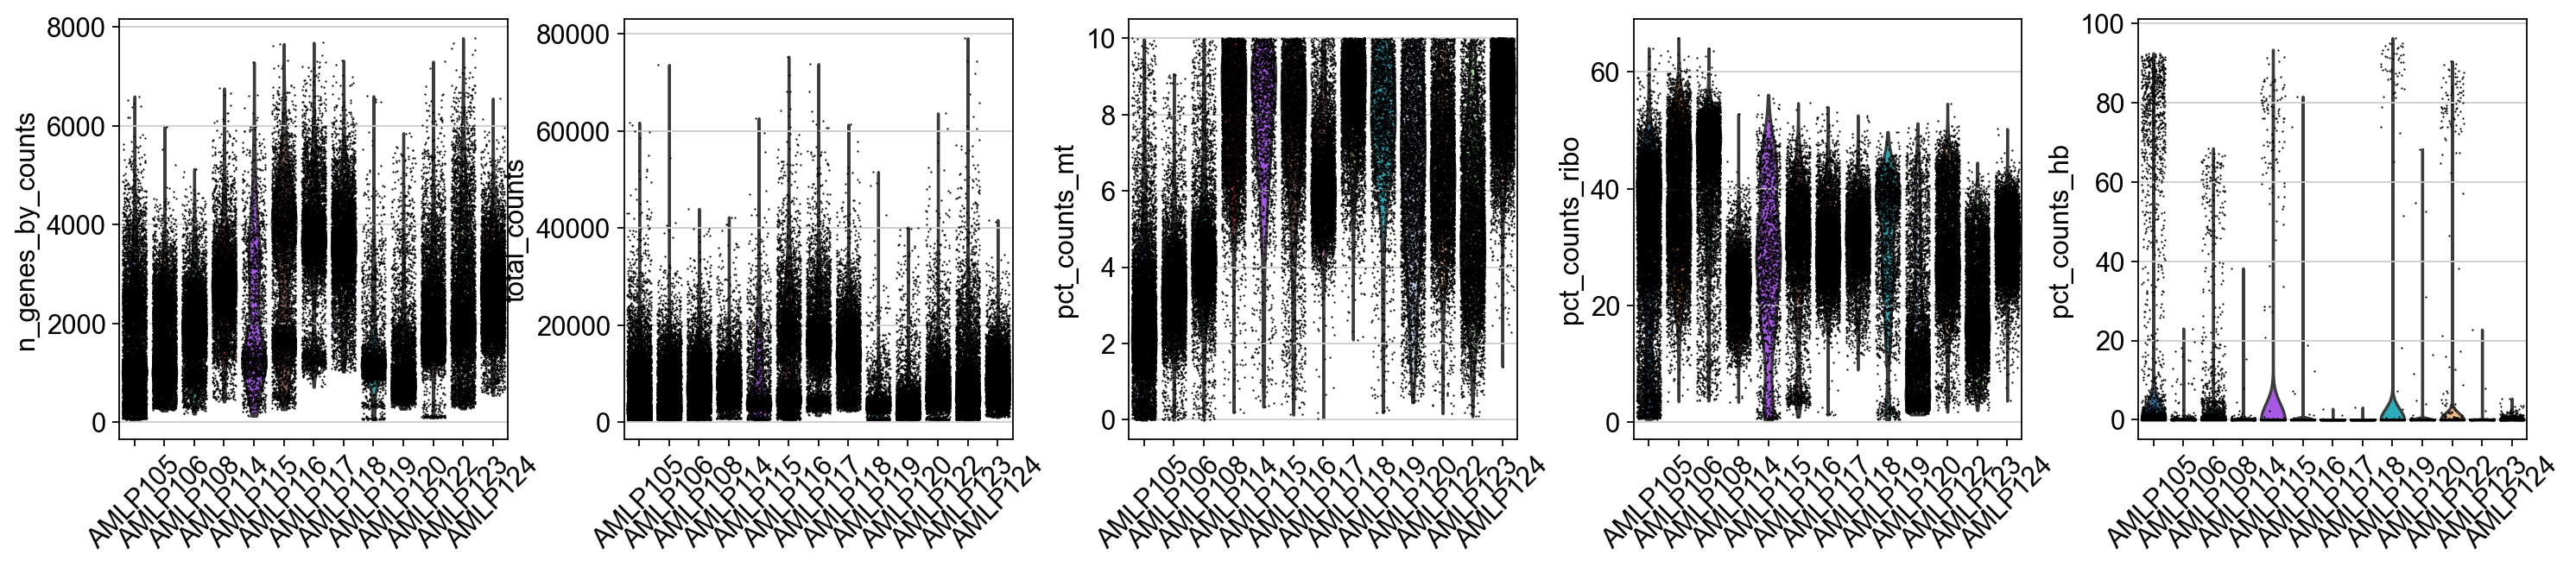

In [7]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'sample', rotation= 45)

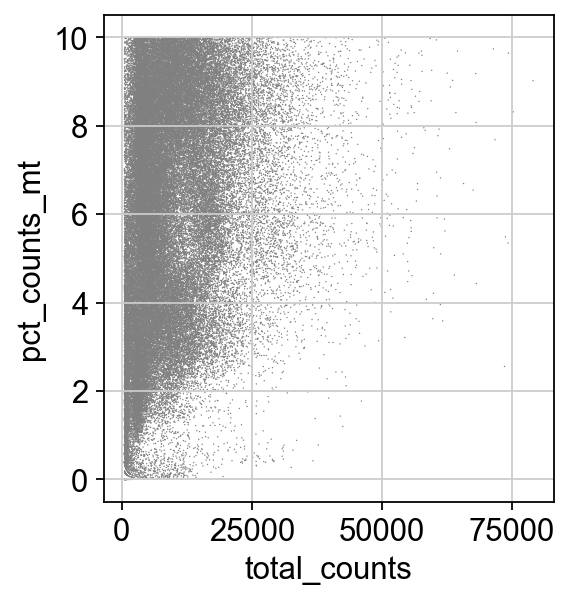

In [8]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')

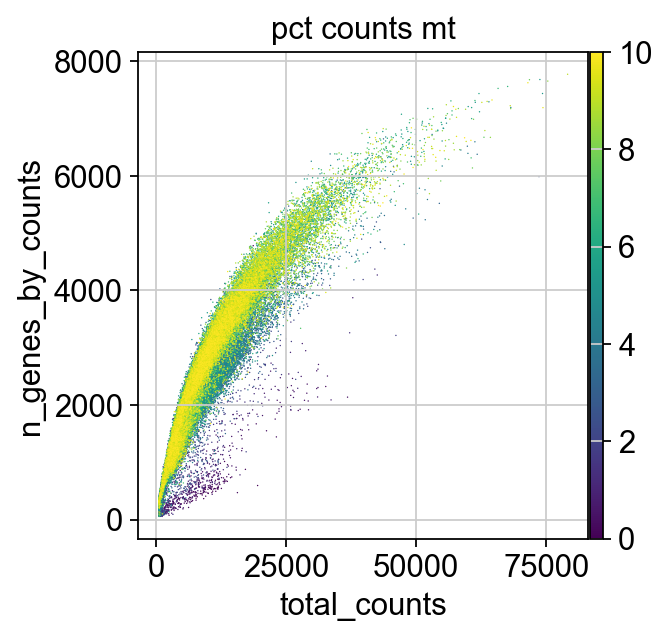

In [9]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt')

### Perform Gene Filtering

In [10]:
sc.pp.filter_genes(adata, min_cells=10)
print(adata.n_obs, adata.n_vars)

filtered out 11582 genes that are detected in less than 10 cells


75648 21956

normalizing counts per cell
    finished (0:00:01)


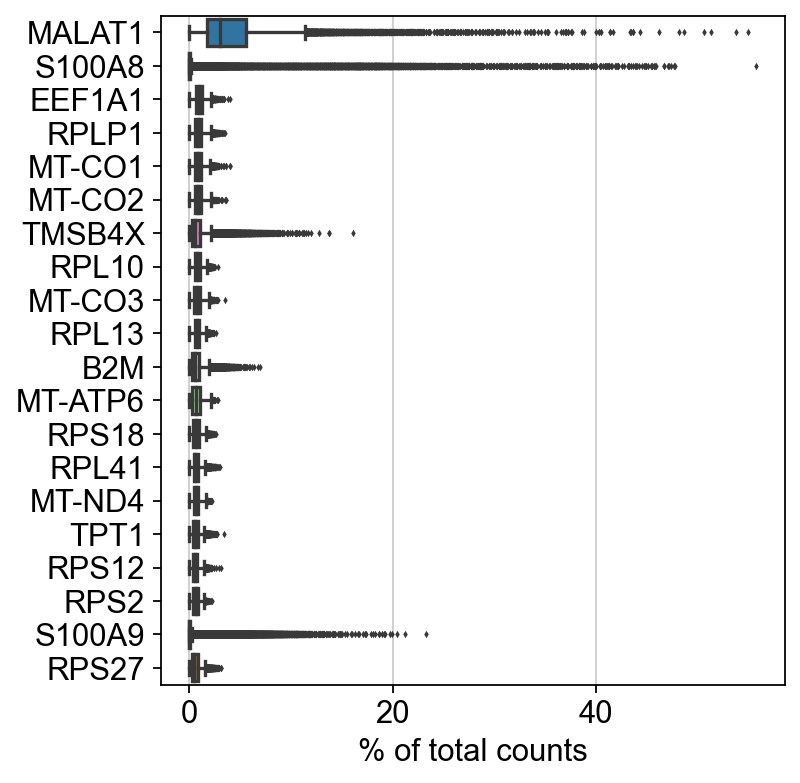

In [11]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [12]:
# MALAT1 Filtering
malat1 = adata.var_names.str.startswith('MALAT1')
keep = np.invert(malat1)
adata = adata[:,keep]
print(adata.n_obs, adata.n_vars)

75648 21955

/Users/jwhittle/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:01)


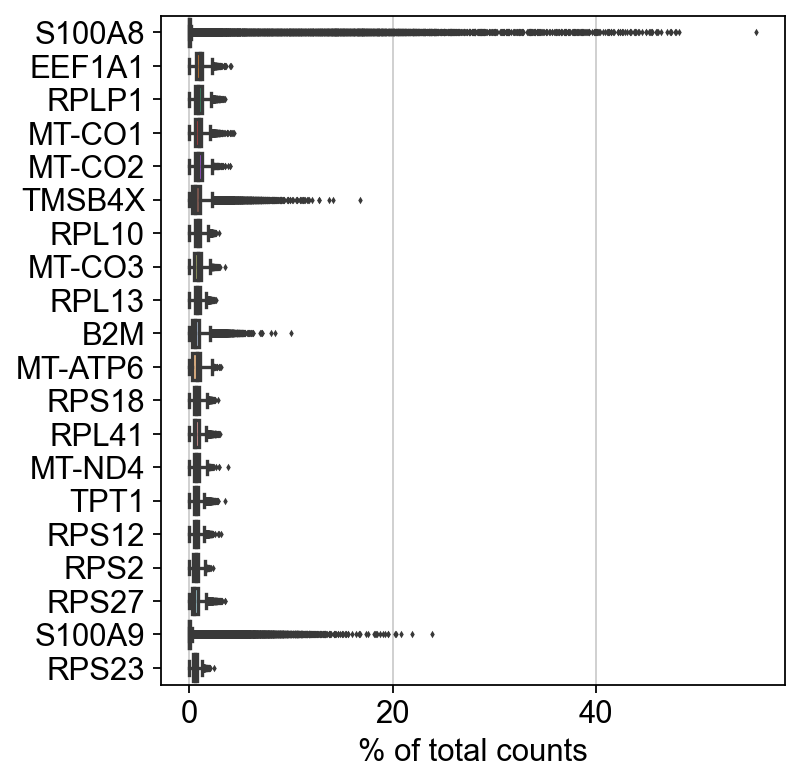

In [13]:
sc.pl.highest_expr_genes(adata, n_top=20)

### Annotate Patient Sex

In [14]:
# Using biomart to identify relevant genes
annot = sc.queries.biomart_annotations(
        "hsapiens",
        ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"],
    ).set_index("external_gene_name")

In [15]:
# Find percentage chrY
chrY_genes = adata.var_names.intersection(annot.index[annot.chromosome_name == "Y"])
adata.obs['percent_chrY'] = np.sum(
    adata[:, chrY_genes].X, axis=1) / np.sum(adata.X, axis=1) * 100

In [16]:
# XIST Proportion
adata.obs["XIST-counts"] = adata.X[:,adata.var_names.str.match('XIST')].toarray()

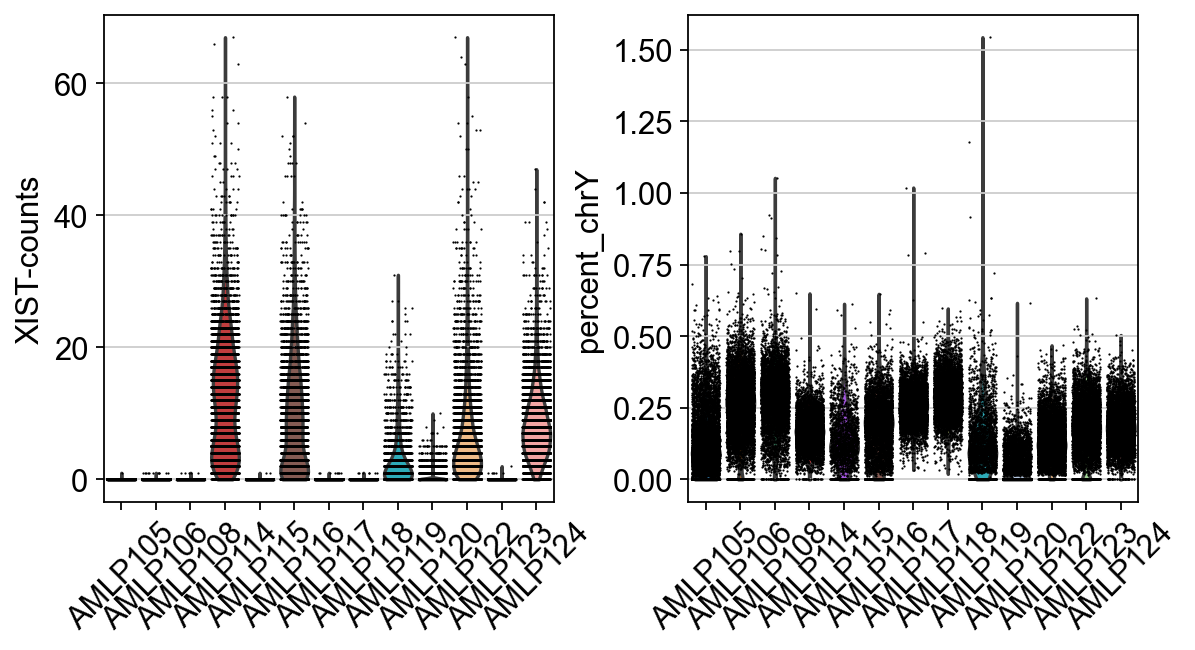

In [17]:
sc.pl.violin(adata, ["XIST-counts", "percent_chrY"], groupby = 'sample', 
             rotation=45, jitter=0.4)

## Pre-Processing Steps Complete!

In [18]:
adata.layers["counts"] = adata.X.copy()
adata.write_h5ad(combined_file)

## Batch Effect Assessment

### Dimensionality Reduction

In [19]:
# Log normalization
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:01)


In [20]:
# Get highly variable genes
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="sample",
    subset=True,
)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)


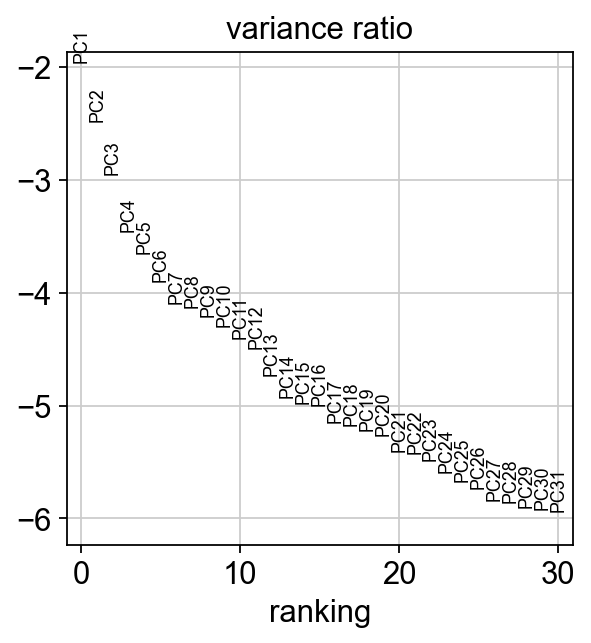

In [21]:
# PCA
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

computing neighbors
    using 'X_pca' with n_pcs = 30


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:27)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:43)


/Users/jwhittle/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


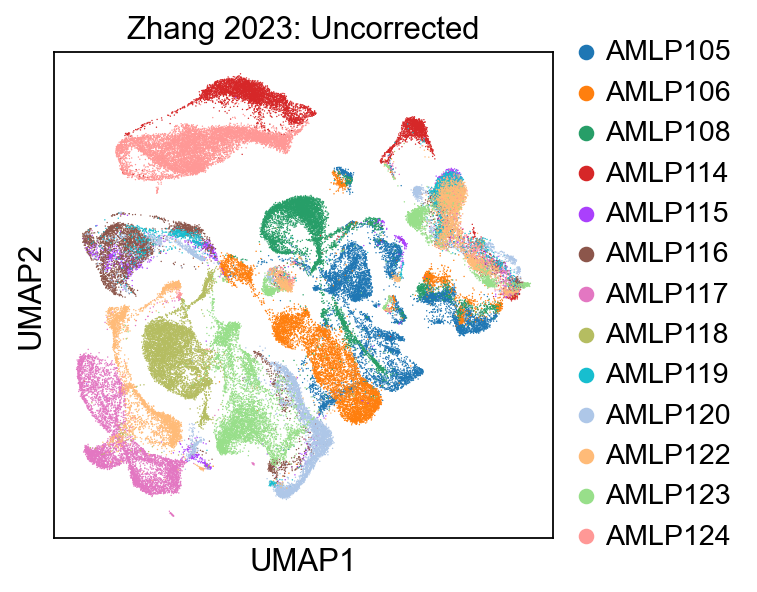

In [22]:
# Calculate neighbours graph
sc.pp.neighbors(adata, n_pcs = 30, n_neighbors = 20)
# UMAP
sc.tl.umap(adata)
sc.pl.umap(adata, color='sample', title='Zhang 2023: Uncorrected')

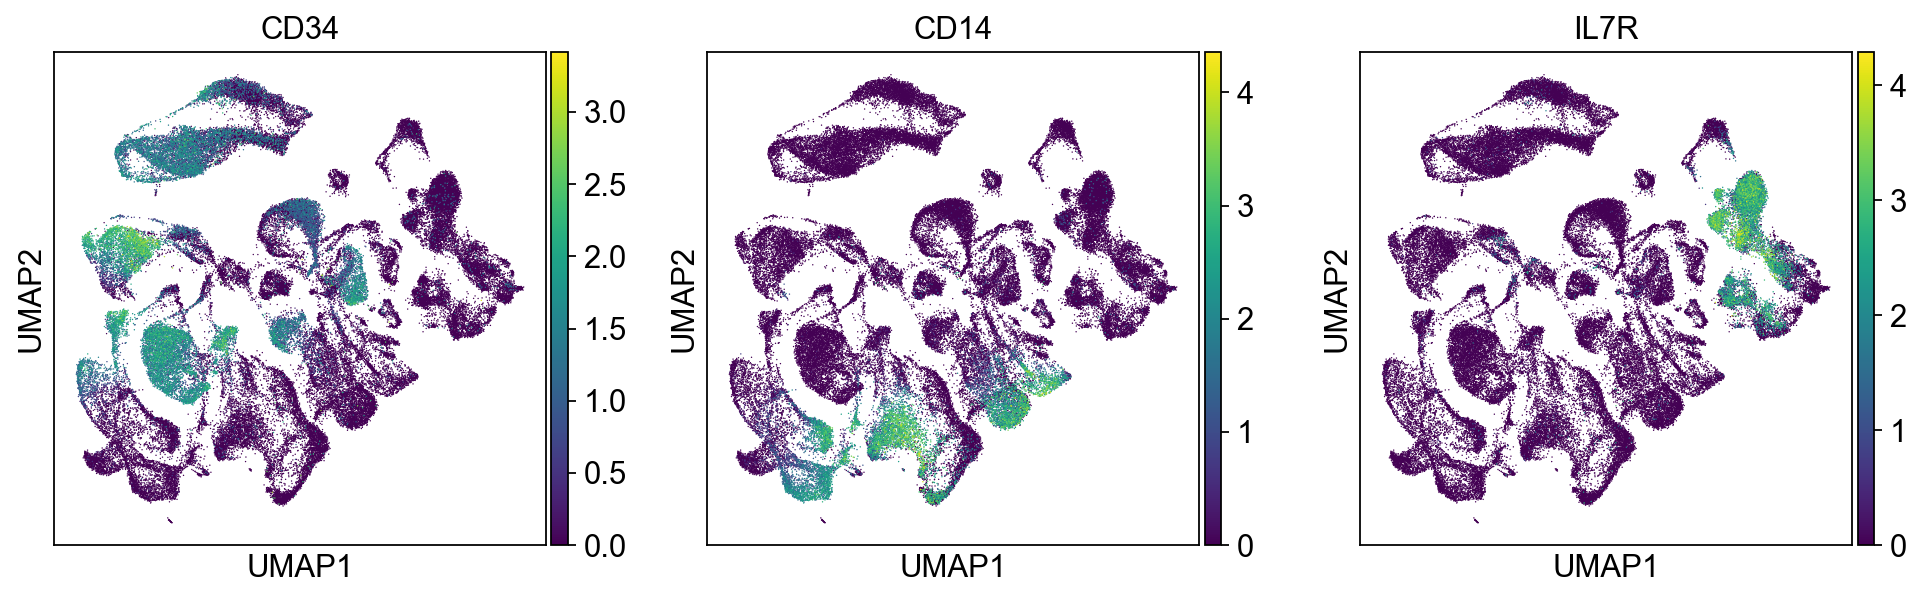

In [23]:
sc.pl.umap(adata, color=["CD34","CD14",'IL7R'])

### KBET

In [24]:
adata_ss = sc.pp.subsample(adata, fraction=0.2, copy=True)

In [25]:
# Make Expression Matrix
count = pd.DataFrame(adata_ss.X.A, columns=adata_ss.var.index, index = adata_ss.obs.index).T

# Get batch ids
batch = adata_ss.obs["sample"]

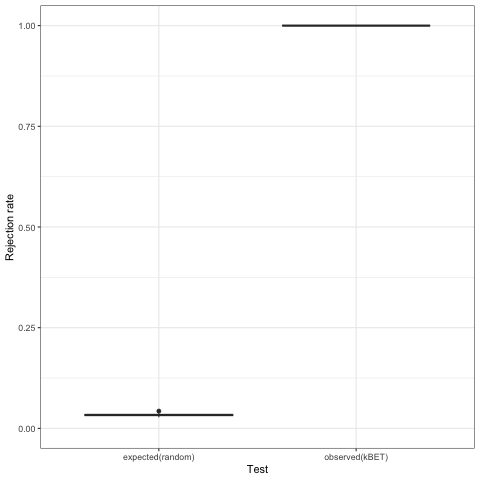

In [26]:
%%R -i count,batch

batch <- as.factor(batch)
batch.estimate <- kBET(count, batch)

### Harmony

In [27]:
sce.pp.harmony_integrate(adata, 'sample')

2024-10-14 22:06:07,975 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-10-14 22:06:23,324 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-10-14 22:06:23,502 - harmonypy - INFO - Iteration 1 of 10
2024-10-14 22:06:37,751 - harmonypy - INFO - Iteration 2 of 10
2024-10-14 22:06:51,844 - harmonypy - INFO - Iteration 3 of 10
2024-10-14 22:07:05,849 - harmonypy - INFO - Iteration 4 of 10
2024-10-14 22:07:21,499 - harmonypy - INFO - Iteration 5 of 10
2024-10-14 22:07:31,877 - harmonypy - INFO - Converged after 5 iterations


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:39)


/Users/jwhittle/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


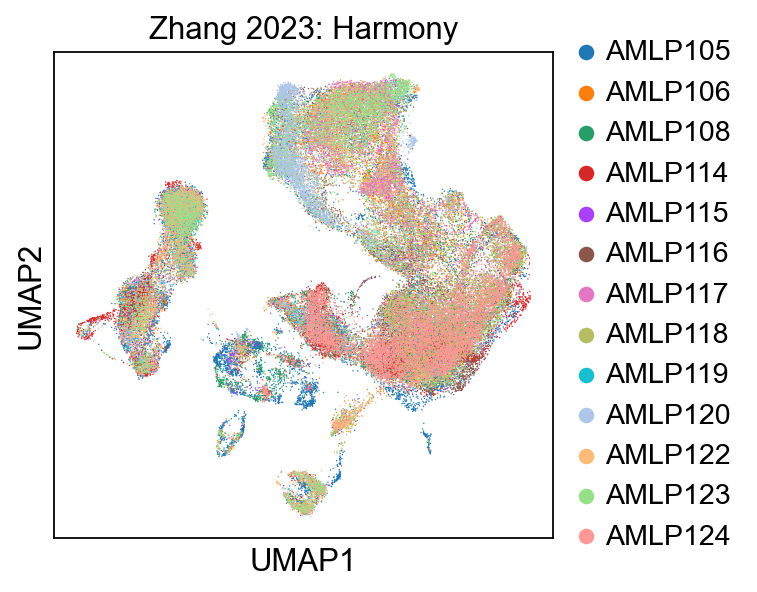

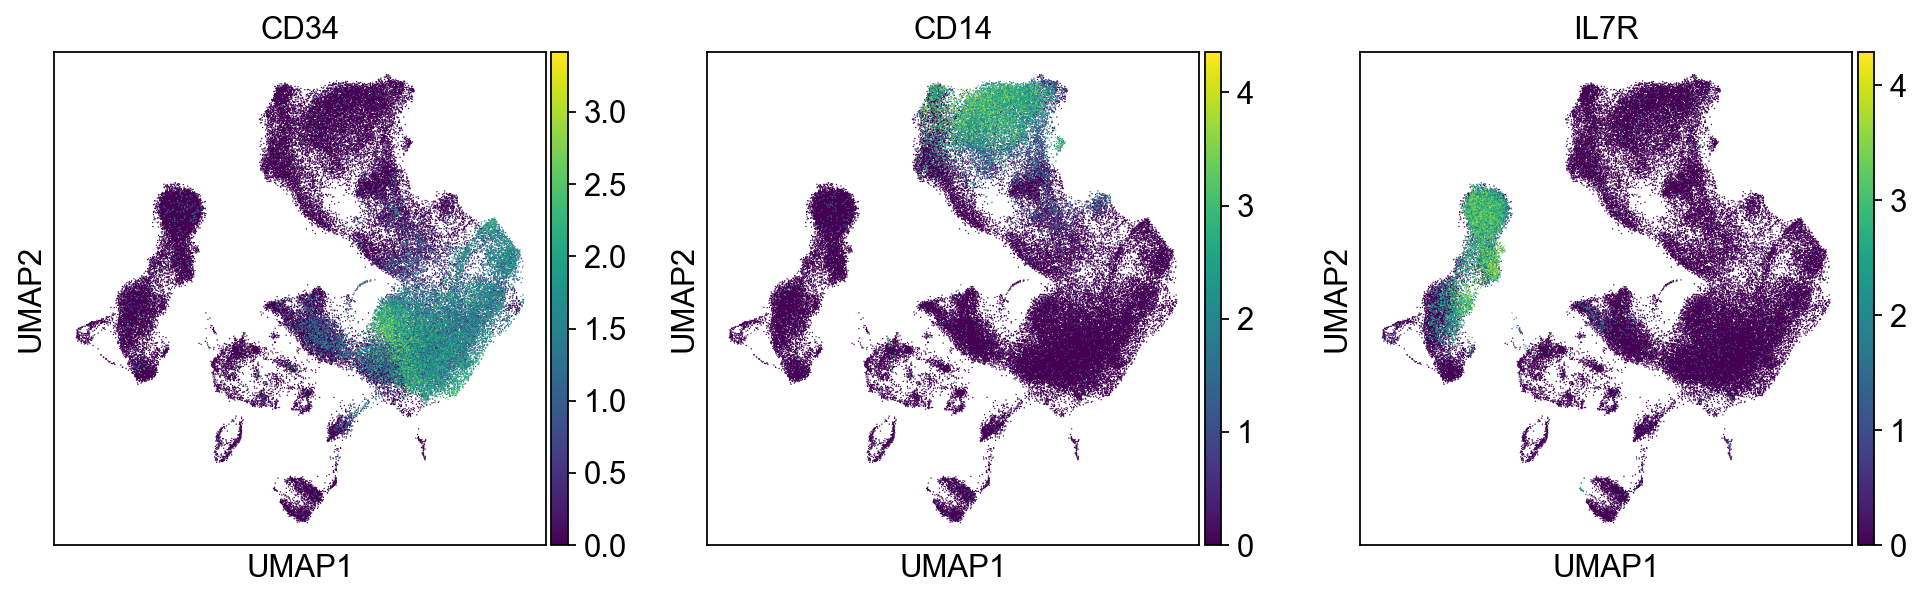

In [28]:
sc.pp.neighbors(adata, use_rep="X_pca_harmony")
sc.tl.umap(adata)
sc.pl.umap(adata, color='sample', title='Zhang 2023: Harmony')
sc.pl.umap(adata, color=["CD34","CD14",'IL7R'])

### scVI

In [29]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="sample")

In [30]:
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

In [31]:
vae.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/jwhittle/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 106/106: 100%|███████| 106/106 [16:35<00:00,  9.38s/it, loss=707, v_num=1]

`Trainer.fit` stopped: `max_epochs=106` reached.


Epoch 106/106: 100%|███████| 106/106 [16:35<00:00,  9.40s/it, loss=707, v_num=1]


In [32]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:36)


/Users/jwhittle/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


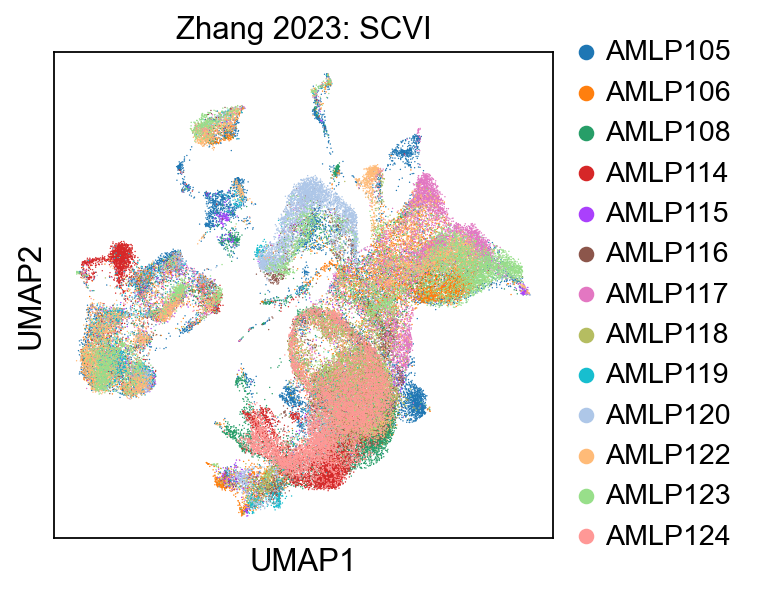

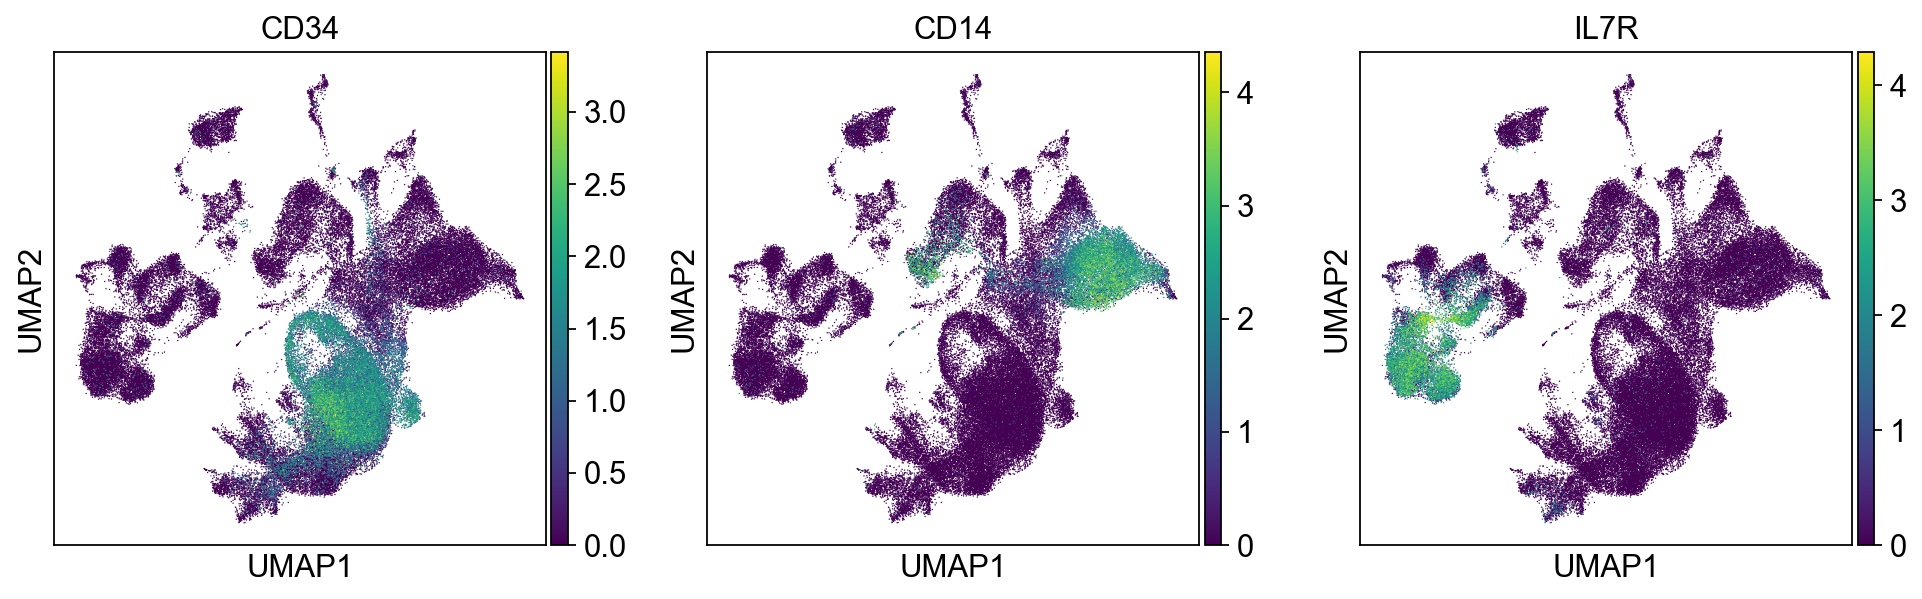

In [33]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)
sc.pl.umap(adata, color='sample', title='Zhang 2023: SCVI')
sc.pl.umap(adata, color=["CD34","CD14",'IL7R'])

## Batch Correction Complete

In [34]:
adata.write_h5ad(corrected_file)

### Reproducibility: Environment Configuration

In [35]:
!conda list

# packages in environment at /Users/jwhittle/opt/anaconda3:
#
# Name                    Version                   Build  Channel
_ipyw_jlab_nb_ext_conf    0.1.0            py39hca03da5_1  
absl-py                   1.4.0                    pypi_0    pypi
adjusttext                1.2.0                    pypi_0    pypi
aiohttp                   3.8.4                    pypi_0    pypi
aiosignal                 1.3.1                    pypi_0    pypi
alabaster                 0.7.12             pyhd3eb1b0_0  
anaconda                  2022.10                  py39_0  
anaconda-client           1.11.0           py39hca03da5_0  
anaconda-navigator        2.3.1            py39hca03da5_0  
anaconda-project          0.11.1           py39hca03da5_0  
anndata                   0.8.0                    pypi_0    pypi
annoy                     1.17.1                   pypi_0    pypi
anyio                     3.5.0            py39hca03da5_0  
appdirs                   1.4.4              pyhd3eb1b0